<a href="https://colab.research.google.com/github/jazaineam1/nopara/blob/main/Cuadernos/Regresion_No__Para1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regresión no paramétrica

Se trata de métodos que no suponen ninguna forma concreta de la media condicional (i.e. no se hacen suposiciones paramétricas sobre el efecto de las variables explicativas):
$$Y=m\left( X_1, \ldots,  X_p \right) + \varepsilon$$
siendo $m$ una función "cualquiera" (se asume que es una función "suave" de los predictores).

La idea detrás de la mayoría de estos métodos es ajustar localmente un modelo de regresión (este capítulo se podría haber titulado "modelos locales").
Suponiendo que disponemos de "suficiente" información en un entorno de la posición de predicción (el número de observaciones debe ser relativamente grande), podríamos pensar en predecir la respuesta a partir de lo que ocurre en las observaciones cercanas.

Nos centraremos principalmente en el caso de regresión, pero la mayoría de estos métodos se pueden extender para el caso de clasificación (por ejemplo considerando una función de enlace y realizando el ajuste localmente por máxima verosimilitud).

Los métodos de regresión basados en: árboles de decisión, bosques aleatorios, bagging, boosting y máquinas de soporte vectorial, vistos en capítulos anteriores, entrarían también dentro de esta clasificación.


## Regresión local

En este tipo de métodos se incluirían: vecinos más próximos, regresión tipo núcleo y loess (o lowess).
También se podrían incluir los *splines de regresión* (*regression splines*), pero se tratarán en la siguiente sección, ya que también se pueden ver como una extensión de un modelo lineal global.

Con muchos de estos procedimientos no se obtiene una expresión cerrada del modelo ajustado y (en principio) es necesario disponer de la muestra de entrenamiento para calcular predicciones, por lo que en AE también se denominan *métodos basados en memoria*.


### Vecinos más próximos

Uno de los métodos más conocidos de regresión local es el denominado *k-vecinos más cercanos* (*k-nearest neighbors*; KNN).
Se trata de un método muy simple, pero que en la práctica puede ser efectivo en muchas ocasiones.
Se basa en la idea de que localmente la media condicional (la predicción óptima) es constante.
Concretamente, dados un entero $k$ (hiperparámetro) y un conjunto de entrenamiento $\mathcal{T}$, para obtener la predicción correspondiente a un vector de valores de las variables explicativas $\mathbf{x}$, el método de regresión KNN promedia las observaciones en un vecindario $\mathcal{N}_k(\mathbf{x}, \mathcal{T})$ formado por las $k$ observaciones más cercanas a $\mathbf{x}$:
$$\hat{Y}(\mathbf{x}) = \hat{m}(\mathbf{x}) = \frac{1}{k} \sum_{i \in \mathcal{N}_k(\mathbf{x}, \mathcal{T})} Y_i$$

Para ver más distancias (https://ichi.pro/es/9-medidas-de-distancia-en-ciencia-de-datos-159983401462266)


Se puede emplear la misma idea en el caso de clasificación, las frecuencias relativas en el vecindario serían las estimaciones de las probabilidades de las clases (lo que sería equivalente a considerar las variables indicadoras de las categorías) y normalmente la predicción sería la moda (la clase más probable).

Para seleccionar el vecindario es necesario especificar una distancia, por ejemplo:
$$d(\mathbf{x}_0, \mathbf{x}_i) = \left( \sum_{j=1}^p \left| x_{j0} - x_{ji}  \right|^d  \right)^{\frac{1}{d}}$$
Normalmente se considera la distancia euclídea ($d=2$) o la de Manhatan ($d=1$) si los predictores son muméricos (también habría distancias diseñadas para predictores categóricos).
En cualquier caso la recomendación es estandarizar previamente los predictores para que no influya su escala en el cálculo de las distancias.


Como ejemplo adicional emplearemos el conjunto de datos `MASS::mcycle` que contiene mediciones de la aceleración de la cabeza en una simulación de un accidente de motocicleta, utilizado para probar cascos protectores (considerando el conjunto de datos completo como si fuese la muestra de entrenamiento;

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘Rcpp’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’


Loading required package: ggplot2

Loading required package: lattice



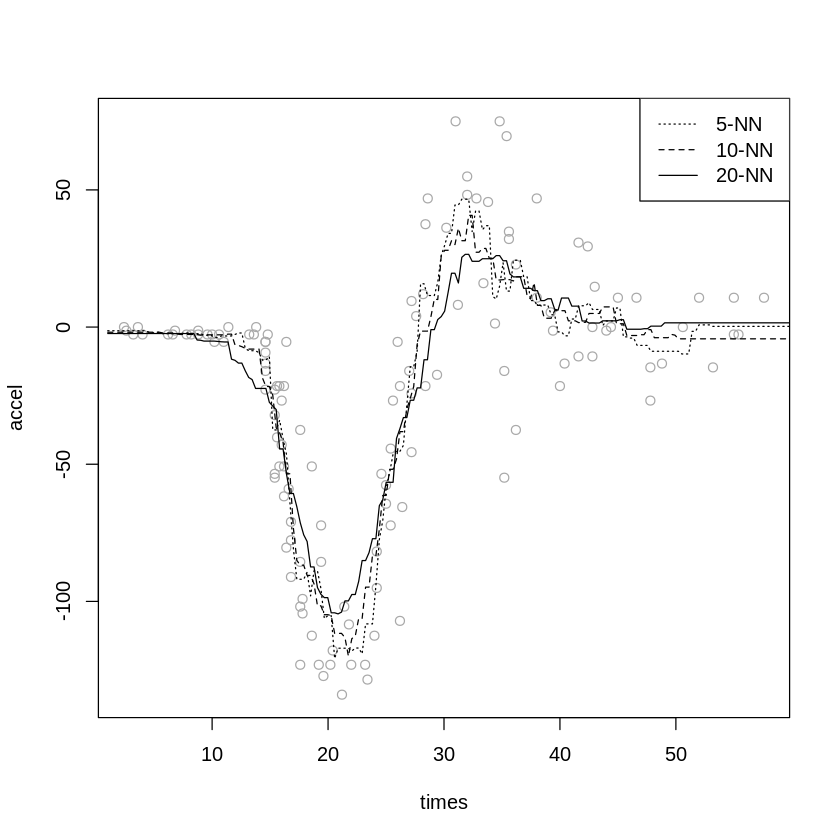

In [ ]:
data(mcycle, package = "MASS")
install.packages('caret')
library(caret)
# Ajuste de los modelos
fit1 <- knnreg(accel ~ times, data = mcycle, k = 5) # 5% de los datos
fit2 <- knnreg(accel ~ times, data = mcycle, k = 10)
fit3 <- knnreg(accel ~ times, data = mcycle, k = 20)
# Representación
plot(accel ~ times, data = mcycle, col = 'darkgray')
newx <- seq(1 , 60, len = 200)
newdata <- data.frame(times = newx)
lines(newx, predict(fit1, newdata), lty = 3)
lines(newx, predict(fit2, newdata), lty = 2)
lines(newx, predict(fit3, newdata))
legend("topright", legend = c("5-NN", "10-NN", "20-NN"),
       lty = c(3, 2, 1), lwd = 1)


El hiperparámetro $k$ (número de vecinos más cercanos) determina la complejidad del modelo, de forma que valores más pequeños de $k$ se corresponden con modelos más complejos (en el caso extremo $k = 1$ se interpolarían las observaciones).


### Regresión polinómica local
En el caso univariante, para cada $x_0$ se ajusta un polinomio de grado $d$:
$$\beta_0+\beta_{1}\left(x - x_0\right) + \cdots
+ \beta_{d}\left( x-x_0\right)^{d}$$
por mínimos cuadrados ponderados, con pesos
$$w_{i} = K_h(x - x_0) = \frac{1}{h}K\left(\frac{x-x_0}{h}\right)$$
donde $K$ es una función núcleo (normalmente una densidad simétrica en torno al cero) y $h>0$ es un parámetro de suavizado, llamado ventana, que regula el tamaño del entorno que se usa para llevar a cabo el ajuste
(esta ventana también se puede suponer local, $h \equiv h(x_0)$; por ejemplo el método KNN se puede considerar un caso particular, con $d=0$ y $K$ la densidad de una $\mathcal{U}(-1, 1)$).
A partir de este ajuste^[Se puede pensar que se están estimando los coeficientes de un desarrollo de Taylor de $m(x_0)$.]:

-   La estimación en $x_0$ es $\hat{m}_{h}(x_0)=\hat{\beta}_0$.

-   Podemos obtener también estimaciones de las derivadas:
    $\widehat{m_{h}^{(r)}}(x_0) = r!\hat{\beta}_{r}$.

Por tanto, la estimación polinómica local de grado $d$, $\hat{m}_{h}(x)=\hat{\beta}_0$, se obtiene al minimizar:
$$\min_{\beta_0 ,\beta_1, \ldots, \beta_d} \sum_{i=1}^{n}\left\{ Y_{i} - \beta_0
- \beta_1(x - X_i) - \ldots -\beta_d(x - X_i)^d \right\}^{2} K_{h}(x - X_i)$$

Explícitamente:
$$\hat{m}_{h}(x) = \mathbf{e}_{1}^{t} \left(
X_{x}^{t} {W}_{x}
X_{x} \right)^{-1} X_{x}^{t}
{W}_{x}\mathbf{Y} \equiv {s}_{x}^{t}\mathbf{Y}$$
donde $\mathbf{e}_{1} = \left( 1, \cdots, 0\right)^{t}$, $X_{x}$
es la matriz con $(1,x - X_i, \ldots, (x - X_i)^d)$ en la fila $i$,
$W_{x} = \mathtt{diag} \left( K_{h}(x_{1} - x), \ldots, K_{h}(x_{n} - x) \right)$
es la matriz de pesos, e $\mathbf{Y} = \left( Y_1, \cdots, Y_n\right)^{t}$ es el vector de observaciones de la respuesta.

Se puede pensar que se obtiene aplicando un suavizado polinómico a
$(X_i, Y_i)$:
$$\hat{\mathbf{Y}} = S\mathbf{Y}$$
siendo $S$ la matriz de suavizado con $\mathbf{s}_{X_{i}}^{t}$ en la fila $i$ (este tipo de métodos también se denominan *suavizadores lineales*).

Habitualmente se considera $d=0$, el estimador Nadaraya-Watson, o $d=1$, estimador lineal local.
Desde el punto de vista asintótico ambos estimadores tienen un comportamiento similar^[Asintóticamente el estimador lineal local tiene un sesgo menor que el de Nadaraya-Watson (pero del mismo orden) y la misma varianza (e.g. @fan1996).], pero en la práctica suele ser preferible el estimador lineal local, sobre todo porque se ve menos afectado por el denominado efecto frontera (Sección \@ref(dimen-curse)).

La ventana $h$ es el (hiper)parámetro de mayor importancia en la predicción y para seleccionarlo se suelen emplear métodos de validación cruzada (Sección \@ref(cv)) o tipo plug-in (reemplazando las funciones desconocidas que aparecen en la expresión de la ventana asintóticamente óptima por estimaciones; e.g. función `dpill()` del paquete `KernSmooth`).
Por ejemplo, usando el criterio de validación cruzada dejando uno fuera (LOOCV) se trataría de minimizar:
$$CV(h)=\frac{1}{n}\sum_{i=1}^n(y_i-\hat{m}_{-i}(x_i))^2$$
siendo $\hat{m}_{-i}(x_i)$ la predicción obtenida eliminando la observación $i$-ésima.
Al igual que en el caso de regresión lineal, este error también se puede obtener a partir del ajuste con todos los datos:
$$CV(h)=\frac{1}{n}\sum_{i=1}^n\left(\frac{y_i-\hat{m}(x_i)}{1 - S_{ii}}\right)^2$$
siendo $S_{ii}$ el elemento $i$-ésimo de la diagonal de la matriz de suavizado (esto en general es cierto para cualquier suavizador lineal).

Alternativamente se podría emplear *validación cruzada generalizada* [@craven1978smoothing]:
$$GCV(h)=\frac{1}{n}\sum_{i=1}^n\left(\frac{y_i-\hat{m}(x_i)}{1 - \frac{1}{n}tr(S)}\right)^2$$
(sustituyendo $S_{ii}$ por su promedio).
Además, la traza de la matriz de suavizado $tr(S)$ es lo que se conoce como el *número efectivo de parámetros* ($n - tr(S)$ sería una aproximación de los grados de libertad del error).

Aunque el paquete base de `R` incluye herramientas para la estimación tipo núcleo de la regresión (`ksmooth()`, `loess()`), recomiendan el uso del paquete `KernSmooth` [@R-KernSmooth].
Continuando con el ejemplo del conjunto de datos `MASS::mcycle` emplearemos la función `locpoly()` de este paquete para obtener estimaciones lineales locales^[La función `KernSmooth::locpoly()` también admite la estimación de derivadas.] con una venta seleccionada mediante un método plug-in `r cite_fig(llr-fit)`:


KernSmooth 2.23 loaded
Copyright M. P. Wand 1997-2009



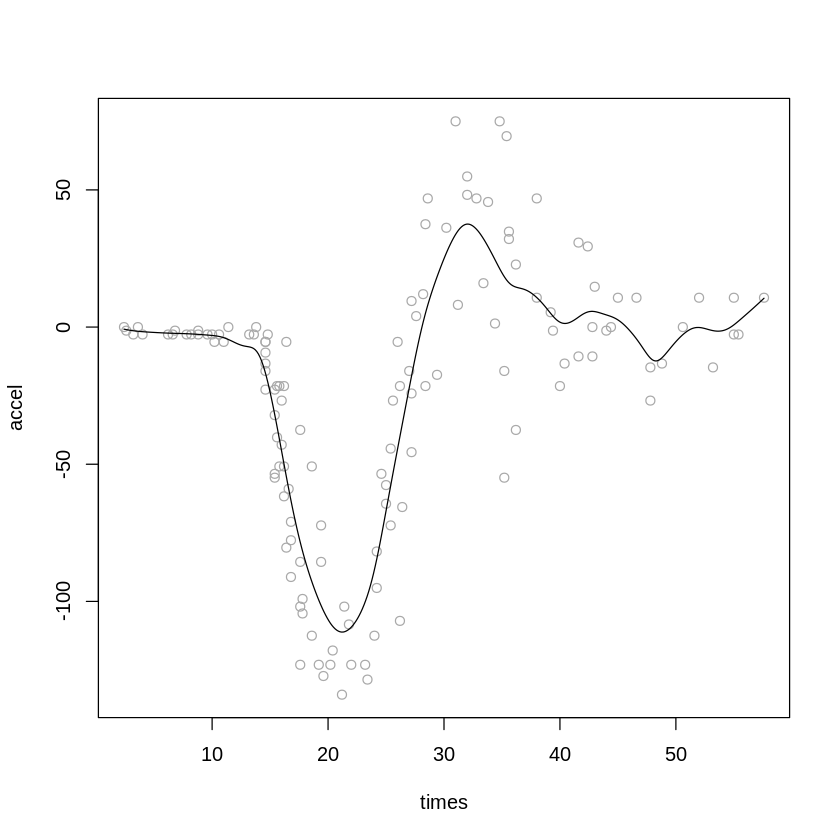

In [ ]:
times <- mcycle$times
accel <- mcycle$accel
library(KernSmooth)
h <- dpill(times, accel) # Método plug-in de Ruppert, Sheather y Wand (1995)
fit <- locpoly(times, accel, bandwidth = h) # Estimación lineal local
plot(times, accel, col = 'darkgray')
lines(fit)

Hay que tener en cuenta que el paquete `KernSmooth` no implementa los métodos
`predict()` y `residuals()`:

In [ ]:
pred <- approx(fit, xout = times)$y # pred <- predict(fit)
resid <- accel - pred # resid <- residuals(fit)

Tampoco calcula medidas de bondad de ajuste, aunque podríamos calcular medidas de la precisión de las predicciones de la forma habitual (en este caso de la muestra de entrenamiento):

In [ ]:
accuracy <- function(pred, obs, na.rm = FALSE,
                     tol = sqrt(.Machine$double.eps)) {
  err <- obs - pred     # Errores
  if(na.rm) {
    is.a <- !is.na(err)
    err <- err[is.a]
    obs <- obs[is.a]
  }
  perr <- 100*err/pmax(obs, tol)  # Errores porcentuales
  return(c(
    me = mean(err),           # Error medio
    rmse = sqrt(mean(err^2)), # Raíz del error cuadrático medio
    mae = mean(abs(err)),     # Error absoluto medio
    mpe = mean(perr),         # Error porcentual medio
    mape = mean(abs(perr)),   # Error porcentual absoluto medio
    r.squared = 1 - sum(err^2)/sum((obs - mean(obs))^2) # Pseudo R-cuadrado
  ))
}
accuracy(pred, accel)

me          rmse           mae           mpe          mape 
-2.712378e-01  2.140005e+01  1.565921e+01 -2.460832e+10  7.559223e+10 
    r.squared 
 8.023864e-01


El caso multivariante es análogo, aunque habría que considerar una matriz de ventanas simétrica $H$. También hay extensiones para el caso de predictores categóricos (nominales o ordinales) y para el caso de distribuciones de la respuesta distintas de la normal (máxima verosimilitud local).

Otros paquetes de R incluyen más funcionalidades (`sm`, `locfit`, `r cite_pkg_("npsp","https://rubenfcasal.github.io/npsp")`...), pero hoy en día el paquete `r cite_pkg_("np","https://github.com/JeffreyRacine/R-Package-np")` es el que se podría considerar más completo.

